In [28]:
%cd /Users/helloworld/Home/Desktop/amugeona/LNS_floating/

/Users/helloworld/Home/Desktop/amugeona/LNS_floating


# Floating Object Surface Dynamics (Vertical Oscillation)

Based on: Galeano-Rios, Milewski, and Vanden-Broeck (2017)

**Extension**: Flat-bottomed rectangular object with prescribed **vertical** oscillation

## Key Physics

**Object Motion**: Vertical oscillation
$$z_{obj}(t) = z_0 + A \sin(\omega t)$$

**Critical Constraint**: Under the object, the fluid surface must match the object's bottom:
$$\eta(x,t) = z_{obj}(t) \quad \text{for } |x - x_c| < R$$

This is a **kinematic constraint** - the fluid cannot penetrate the solid!

**Implementation Strategy**:
1. **Under object**: Directly set $\eta = z_{obj}$ (enforces contact)
2. **Outside object**: Normal evolution via equation (2.15c): $\eta_t = \phi_z + w^3$
3. **Pressure $p_s$**: Computed from the dynamic BC to make $\phi$ consistent

The pressure $p_s$ under the object is whatever is needed to:
- Support the object's weight
- Provide the force for vertical acceleration

In [29]:
import numpy as np
from scipy.sparse import lil_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.patches import Rectangle
import math

In [30]:
import session_info
session_info.show()

## Physical and Numerical Parameters

In [31]:
# ===== PHYSICAL PARAMETERS (same as 02_Surface_Dynamics_updated) =====
L_in_cm = 50.0   # Domain length in x-direction (cm)
D_in_cm = 20.0   # Domain depth in z-direction (cm)
g_accel = 980.0  # Gravitational acceleration (cm/s²)
sigma = 174.9    # Surface tension (dyne/cm)
rho = 1.0        # Density (g/cm³)
nu = 0.0005      # Kinematic viscosity (cm²/s) - water

# ===== FLOATING OBJECT PARAMETERS =====
object_half_width_cm = 5.0       # R = 5 cm → total width = 10 cm
object_center_x_cm = L_in_cm/2   # x-position: center of domain (fixed)

# VERTICAL oscillation parameters
oscillation_amplitude_cm = 0.3   # A = 3 mm vertical amplitude
oscillation_frequency = 25.0     # ω = 25 rad/s → λ ≈ 10 cm

# Object equilibrium position
object_draft_cm = 0.3  # Object sits 3mm below mean water level at rest

# ===== NON-DIMENSIONALIZATION (same as 02_Surface_Dynamics_updated) =====
Unit_length = 2.5   # Length scale (cm)
Unit_time = 0.05    # Time scale (s)
Unit_velocity = Unit_length / Unit_time  # = 50 cm/s

# ===== NUMERICAL PARAMETERS =====
nx = 400   # Grid points in x
nz = 80    # Grid points in z
nt = 4000  # Time steps
total_time = 2.0  # Simulation time (s)

# ===== DIMENSIONLESS QUANTITIES =====
L = L_in_cm / Unit_length
D = D_in_cm / Unit_length
T_total = total_time / Unit_time

# Dimensionless numbers
Fr = (Unit_velocity**2) / (g_accel * Unit_length)
We = (rho * (Unit_velocity**2) * Unit_length) / sigma
Re = (Unit_velocity * Unit_length) / nu

# Object dimensionless parameters
R_obj = object_half_width_cm / Unit_length
x_c_obj = object_center_x_cm / Unit_length
A_obj = oscillation_amplitude_cm / Unit_length
omega_obj = oscillation_frequency * Unit_time
z_draft = object_draft_cm / Unit_length

# Derived numerical constants
dx = L / nx
dz = D / nz
dt = T_total / nt

# Grid vectors
x_vec = np.linspace(0, L, nx, endpoint=False)

# Object masks - SMOOTH transition for wave generation
delta_smooth = 3 * dx  # Smoothing width at object edges
smooth_mask = 0.5 * (np.tanh((x_vec - (x_c_obj - R_obj)) / delta_smooth) - 
                      np.tanh((x_vec - (x_c_obj + R_obj)) / delta_smooth))
# Hard mask for core object region
object_mask = np.abs(x_vec - x_c_obj) < R_obj
object_indices = np.where(object_mask)[0]

# ===== WAVE PROPERTY ESTIMATES =====
wavelength_gravity = 2 * np.pi * g_accel / (oscillation_frequency**2)
c_phase = g_accel / oscillation_frequency
c_group = c_phase / 2
travel_distance = L_in_cm/2 - object_half_width_cm
propagation_time = travel_distance / c_group

print("===== WAVE PHYSICS =====")
print(f"  Frequency ω = {oscillation_frequency:.1f} rad/s, Period T = {2*np.pi/oscillation_frequency*1000:.1f} ms")
print(f"  Wavelength λ ≈ {wavelength_gravity:.1f} cm ({L_in_cm/wavelength_gravity:.1f} wavelengths in domain)")
print(f"  Phase velocity c ≈ {c_phase:.1f} cm/s, Group velocity c_g ≈ {c_group:.1f} cm/s")
print(f"  Wave reaches boundary in ≈ {propagation_time:.3f} s")

print(f"\n===== DIMENSIONLESS NUMBERS =====")
print(f"  Fr = {Fr:.4f}, We = {We:.4f}, Re = {Re:.0f}")

print(f"\n===== OBJECT =====")
print(f"  Width = {2*object_half_width_cm:.1f} cm, Draft = {object_draft_cm*10:.1f} mm")
print(f"  Amplitude A = {oscillation_amplitude_cm*10:.1f} mm")

print(f"\n===== GRID =====")
print(f"  {nx} × {nz} points, dt = {dt*Unit_time*1000:.3f} ms")
print(f"  Points per wavelength ≈ {wavelength_gravity / (dx*Unit_length):.1f}")

===== WAVE PHYSICS =====
  Frequency ω = 25.0 rad/s, Period T = 251.3 ms
  Wavelength λ ≈ 9.9 cm (5.1 wavelengths in domain)
  Phase velocity c ≈ 39.2 cm/s, Group velocity c_g ≈ 19.6 cm/s
  Wave reaches boundary in ≈ 1.020 s

===== DIMENSIONLESS NUMBERS =====
  Fr = 1.0204, We = 35.7347, Re = 250000

===== OBJECT =====
  Width = 10.0 cm, Draft = 3.0 mm
  Amplitude A = 3.0 mm

===== GRID =====
  400 × 80 points, dt = 0.500 ms
  Points per wavelength ≈ 78.8


## Object State Functions

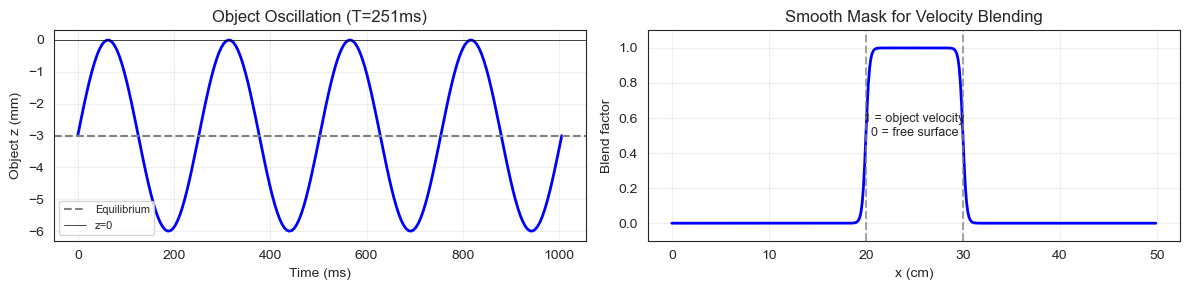

Object oscillates: z ∈ [-6.0, 0.0] mm


In [32]:
def get_object_z(t):
    """Object bottom position: z_obj(t) = -draft + A*sin(ωt)"""
    return -z_draft + A_obj * np.sin(omega_obj * t)

def get_object_vz(t):
    """Object vertical velocity: dz/dt = A*ω*cos(ωt)"""
    return A_obj * omega_obj * np.cos(omega_obj * t)

# Quick visualization of object motion and smooth mask
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Object oscillation
t_test = np.linspace(0, 4 * 2*np.pi/omega_obj, 200)
z_test_mm = np.array([get_object_z(t) for t in t_test]) * Unit_length * 10
axes[0].plot(t_test * Unit_time * 1000, z_test_mm, 'b-', linewidth=2)
axes[0].axhline(-object_draft_cm * 10, color='gray', linestyle='--', label='Equilibrium')
axes[0].axhline(0, color='k', linestyle='-', linewidth=0.5, label='z=0')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Object z (mm)')
axes[0].set_title(f'Object Oscillation (T={2*np.pi/oscillation_frequency*1000:.0f}ms)')
axes[0].legend(fontsize=8)
axes[0].grid(True, alpha=0.3)

# Smooth mask for velocity blending
axes[1].plot(x_vec * Unit_length, smooth_mask, 'b-', linewidth=2)
axes[1].axvline((x_c_obj - R_obj) * Unit_length, color='gray', linestyle='--', alpha=0.7)
axes[1].axvline((x_c_obj + R_obj) * Unit_length, color='gray', linestyle='--', alpha=0.7)
axes[1].set_xlabel('x (cm)')
axes[1].set_ylabel('Blend factor')
axes[1].set_title('Smooth Mask for Velocity Blending')
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(True, alpha=0.3)
axes[1].text(25, 0.5, '1 = object velocity\n0 = free surface', fontsize=9, ha='center')

plt.tight_layout()
plt.show()

print(f"Object oscillates: z ∈ [{(-z_draft-A_obj)*Unit_length*10:.1f}, {(-z_draft+A_obj)*Unit_length*10:.1f}] mm")

## Array Initialization

In [33]:
# Main field arrays
eta = np.zeros(nx)          # Surface elevation η(x, t)
phi = np.zeros((nz, nx))    # Velocity potential φ(x, z, t)
w3 = np.zeros((nz, nx))     # Vertical vortical component w³(x, z, t)
w1 = np.zeros((nz, nx))     # Horizontal vortical component w¹(x, z, t)

# z grid (internal: 0 at bottom, D at surface)
z_vec = np.linspace(0, D, nz)
z_paper = z_vec - D  # Paper coordinates: 0 at surface, -D at bottom

# Initialize η: under object, set to initial object position
z_obj_init = get_object_z(0)
eta[object_mask] = z_obj_init

print(f"Initial object position z_obj = {z_obj_init*Unit_length*10:.3f} mm")
print(f"Initial η under object = {eta[object_indices[0]]*Unit_length*10:.3f} mm")
print(f"Initial η outside object = {eta[0]*Unit_length*10:.3f} mm")

Initial object position z_obj = -3.000 mm
Initial η under object = -3.000 mm
Initial η outside object = 0.000 mm


## Operators

In [34]:
def build_Delta_H(n, dx):
    """Horizontal Laplacian for periodic BC"""
    D = lil_matrix((n, n))
    for j in range(n):
        D[j, j] = -2.0 / dx**2
        D[j, (j+1) % n] = 1.0 / dx**2
        D[j, (j-1) % n] = 1.0 / dx**2
    return D.tocsr()


def build_Laplace_matrix_nonslip(nx_l, nz_l, dx_l, dz_l):
    """Laplace equation with non-slip bottom BC"""
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    alpha = (dz_l / dx_l)**2
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            A[idx, idx] = -2 * alpha - 2
            A[idx, i * nx_l + (j + 1) % nx_l] = alpha
            A[idx, i * nx_l + (j - 1) % nx_l] = alpha
            
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = 1
            else:
                A[idx, (i + 1) * nx_l + j] = 2
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = 1
    
    return A.tocsr()


def build_heat_matrix_2d(nx_l, nz_l, dx_l, dz_l):
    """2D Laplacian for heat equation"""
    N = nx_l * nz_l
    A = lil_matrix((N, N))
    coeff_x = 1.0 / (dx_l**2)
    coeff_z = 1.0 / (dz_l**2)
    
    for i in range(nz_l):
        for j in range(nx_l):
            idx = i * nx_l + j
            A[idx, idx] = -2.0 * coeff_x - 2.0 * coeff_z
            A[idx, i * nx_l + (j + 1) % nx_l] = coeff_x
            A[idx, i * nx_l + (j - 1) % nx_l] = coeff_x
            
            if i > 0:
                A[idx, (i - 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i + 1) * nx_l + j] += coeff_z
            
            if i < nz_l - 1:
                A[idx, (i + 1) * nx_l + j] = coeff_z
            else:
                A[idx, (i - 1) * nx_l + j] += coeff_z
    
    return A.tocsr()


def curvature(eta, dx):
    """Linearized curvature κ[η] = ∂²η/∂x²"""
    kappa = np.zeros_like(eta)
    n = len(eta)
    for j in range(n):
        kappa[j] = (eta[(j+1)%n] - 2*eta[j] + eta[(j-1)%n]) / dx**2
    return kappa


# Build operators
Delta_H = build_Delta_H(nx, dx)
A_laplace = build_Laplace_matrix_nonslip(nx, nz, dx, dz)
Laplacian_2d = build_heat_matrix_2d(nx, nz, dx, dz)
I_1d = eye(nx, format='csr')
I_2d = eye(nx*nz, format='csr')

A_phi_surf = I_1d - (2.0 * dt / Re) * Delta_H
A_w3_surf = I_1d - (2.0 * dt / Re) * Delta_H
A_heat = I_2d - (dt/Re) * Laplacian_2d

# Derivative operator
Dx = lil_matrix((nx, nx))
for j in range(nx):
    Dx[j, (j+1) % nx] = 1.0 / (2*dx)
    Dx[j, (j-1) % nx] = -1.0 / (2*dx)
Dx = Dx.tocsr()

print("Operators built successfully")

Operators built successfully


## Time Stepping Algorithm

**Key modification for floating object:**

1. **Under object**: Enforce kinematic constraint $\eta = z_{obj}(t)$
2. **Outside object**: Normal evolution $\eta_t = \phi_z + w^3$

The pressure $p_s$ is implicitly determined by requiring the velocity potential to be consistent with the constrained surface motion.

In [35]:
%%time
print(f"=== Simulation: Floating Object with Wave Generation ===")
print(f"Domain: {L_in_cm}×{D_in_cm} cm, Grid: {nx}×{nz}, dt={dt*Unit_time*1000:.3f}ms")
print(f"Object: {2*object_half_width_cm}cm wide, A={oscillation_amplitude_cm*10:.1f}mm, ω={oscillation_frequency}rad/s")
print(f"Expected wavelength: {wavelength_gravity:.1f}cm\n")

# History arrays
eta_history = []
phi_history = []
time_points = []
save_every = max(1, nt//100)

# Object state history
object_z_history = []

# Metrics
energy_history = []
max_eta_history = []

print("Starting simulation...")

for n in range(nt):
    t_current = n * dt
    t_next = (n + 1) * dt
    
    # Object state
    z_obj_current = get_object_z(t_current)
    z_obj_next = get_object_z(t_next)
    vz_obj = get_object_vz(t_current)  # Object vertical velocity
    
    #! Step 1: Evolve w³ and w¹ via heat equation (2.15b)
    w3_flat = w3.flatten()
    w3_new_flat = spsolve(A_heat, w3_flat)
    w3_new = w3_new_flat.reshape((nz, nx))
    
    # w³ Surface BC: equation (2.15e)
    phi_z_surf_old = (phi[-1, :] - phi[-2, :]) / dz
    b_w3_surf = w3[-1, :] + (2.0 * dt / Re) * Delta_H.dot(phi_z_surf_old)
    w3_new[-1, :] = spsolve(A_w3_surf, b_w3_surf)
    
    # w³ Bottom BC: non-slip
    phi_z_bottom = (phi[1, :] - phi[0, :]) / dz
    w3_new[0, :] = -phi_z_bottom

    # w¹ evolution
    w1_flat = w1.flatten()
    w1_new_flat = spsolve(A_heat, w1_flat)
    w1_new = w1_new_flat.reshape((nz, nx))
    
    phi_x_bottom = Dx.dot(phi[0, :])
    w1_new[0, :] = -phi_x_bottom
    
    phi_xz_surf = Dx.dot((phi[-1, :] - phi[-2, :]) / dz)
    w3_x_surf = Dx.dot(w3_new[-1, :])
    w1_new[-1, :] = w1_new[-2, :] - dz * (phi_xz_surf + w3_x_surf)

    #! Step 2: Update φ at surface (equation 2.15d)
    kappa_eta = curvature(eta, dx)
    phi_surf = phi[-1, :].copy()
    w3_z_surf = (w3_new[-1, :] - w3_new[-2, :]) / dz
    
    b_phi = (phi_surf 
             - (dt / Fr) * eta 
             + (dt / We) * kappa_eta 
             - (2.0 * dt / Re) * w3_z_surf)
    
    phi_surf_new = spsolve(A_phi_surf, b_phi)

    #! Step 3: Solve Laplace equation for φ in bulk (2.15a)
    b_laplace = np.zeros(nx * nz)
    for j in range(nx):
        b_laplace[(nz-1)*nx + j] = -phi_surf_new[j]
    for j in range(nx):
        b_laplace[j] += -2.0 * dz * w3_new[0, j]
    
    phi_vec = spsolve(A_laplace, b_laplace)
    phi_new = phi_vec.reshape((nz, nx))

    #! Step 4: Update η with SMOOTH BLENDING for wave generation
    phi_z_surf = (phi_new[-1, :] - phi_new[-2, :]) / dz
    w3_surf = w3_new[-1, :]
    
    # Free surface vertical velocity
    vz_free = phi_z_surf + w3_surf
    
    # CRITICAL: Blend object velocity with free surface velocity using smooth mask
    # This creates waves at the object edges instead of a hard discontinuity
    vz_blended = smooth_mask * vz_obj + (1.0 - smooth_mask) * vz_free
    
    # Update η using blended velocity
    eta_new = eta + dt * vz_blended
    
    #! Update variables
    eta = eta_new.copy()
    phi = phi_new.copy()
    w3 = w3_new.copy()
    w1 = w1_new.copy()
    
    #! Save for visualization
    if n % save_every == 0:
        eta_history.append(eta.copy())
        phi_history.append(phi.copy())
        time_points.append((n + 1) * dt * Unit_time)
        object_z_history.append(z_obj_current)
        
        # Metrics (outside object core)
        free_mask = ~object_mask
        KE = 0.5 * np.sum(phi**2) * dx * dz
        PE = (1/Fr) * np.sum(eta[free_mask]**2) * dx
        energy_history.append(KE + PE)
        max_eta_history.append(np.max(np.abs(eta[free_mask])))
    
    # Progress
    if n < 5 or (n+1) % (nt//10) == 0:
        max_eta_free = np.max(np.abs(eta[~object_mask])) * Unit_length * 10
        print(f"  Step {n+1:5d} | t={t_current*Unit_time:.4f}s | max|η|_free={max_eta_free:.3f}mm")

print(f"\nSimulation complete!")

=== Simulation: Floating Object with Wave Generation ===
Domain: 50.0×20.0 cm, Grid: 400×80, dt=0.500ms
Object: 10.0cm wide, A=3.0mm, ω=25.0rad/s
Expected wavelength: 9.9cm

Starting simulation...
  Step     1 | t=0.0000s | max|η|_free=0.017mm
  Step     2 | t=0.0005s | max|η|_free=0.035mm
  Step     3 | t=0.0010s | max|η|_free=0.052mm
  Step     4 | t=0.0015s | max|η|_free=0.069mm
  Step     5 | t=0.0020s | max|η|_free=0.086mm
  Step   400 | t=0.1995s | max|η|_free=1.776mm
  Step   800 | t=0.3995s | max|η|_free=1.298mm
  Step  1200 | t=0.5995s | max|η|_free=0.477mm
  Step  1600 | t=0.7995s | max|η|_free=0.912mm
  Step  2000 | t=0.9995s | max|η|_free=0.641mm
  Step  2400 | t=1.1995s | max|η|_free=1.939mm
  Step  2800 | t=1.3995s | max|η|_free=1.084mm
  Step  3200 | t=1.5995s | max|η|_free=0.748mm
  Step  3600 | t=1.7995s | max|η|_free=0.985mm
  Step  4000 | t=1.9995s | max|η|_free=0.659mm

Simulation complete!
CPU times: user 13min 38s, sys: 2min 2s, total: 15min 40s
Wall time: 16min 3

## Visualization

In [36]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['axes.grid'] = False
import seaborn as sns
sns.set_style("white")

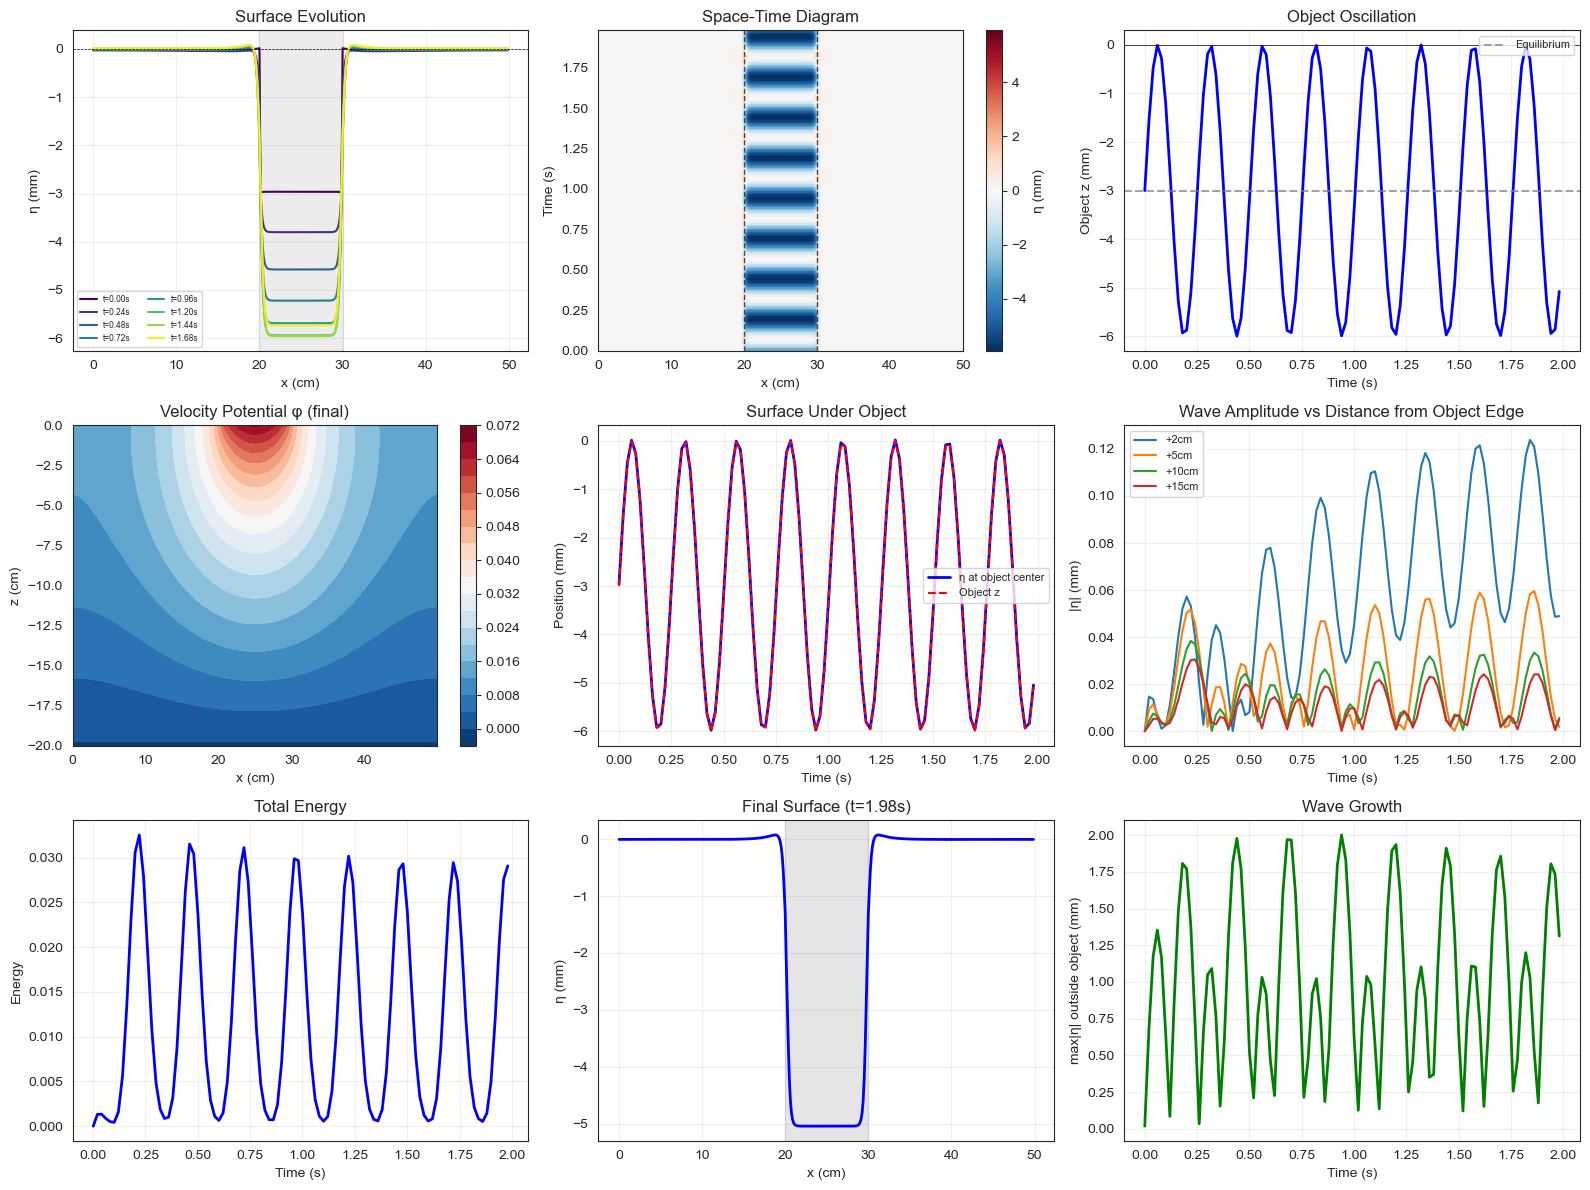

In [37]:
# Convert to physical coordinates
x_cm = x_vec * Unit_length
z_cm = z_paper * Unit_length
X_cm, Z_cm = np.meshgrid(x_cm, z_cm)
obj_left = (x_c_obj - R_obj) * Unit_length
obj_right = (x_c_obj + R_obj) * Unit_length

fig = plt.figure(figsize=(16, 12))

#! 1. Surface evolution
ax1 = fig.add_subplot(3, 3, 1)
n_curves = 8
step = max(1, len(eta_history) // n_curves)
colors = plt.cm.viridis(np.linspace(0, 1, n_curves))
for i, color in enumerate(colors):
    idx = min(i * step, len(eta_history)-1)
    eta_mm = eta_history[idx] * Unit_length * 10
    ax1.plot(x_cm, eta_mm, linewidth=1.5, color=color, label=f't={time_points[idx]:.2f}s')
ax1.axvspan(obj_left, obj_right, alpha=0.15, color='gray')
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('η (mm)')
ax1.set_title('Surface Evolution')
ax1.legend(fontsize=6, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.5)

#! 2. Space-time diagram
ax2 = fig.add_subplot(3, 3, 2)
eta_matrix = np.array(eta_history) * Unit_length * 10
vmax = max(1, np.percentile(np.abs(eta_matrix), 99))
im = ax2.imshow(eta_matrix, aspect='auto', origin='lower',
                extent=[0, L_in_cm, 0, time_points[-1]], 
                cmap='RdBu_r', vmin=-vmax, vmax=vmax)
ax2.axvline(obj_left, color='k', linestyle='--', linewidth=1, alpha=0.7)
ax2.axvline(obj_right, color='k', linestyle='--', linewidth=1, alpha=0.7)
ax2.set_xlabel('x (cm)')
ax2.set_ylabel('Time (s)')
ax2.set_title('Space-Time Diagram')
plt.colorbar(im, ax=ax2, label='η (mm)')

#! 3. Object oscillation
ax3 = fig.add_subplot(3, 3, 3)
obj_z_mm = np.array(object_z_history) * Unit_length * 10
ax3.plot(time_points, obj_z_mm, 'b-', linewidth=2)
ax3.axhline(-object_draft_cm*10, color='gray', linestyle='--', alpha=0.7, label='Equilibrium')
ax3.axhline(0, color='k', linestyle='-', linewidth=0.5)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Object z (mm)')
ax3.set_title('Object Oscillation')
ax3.legend(fontsize=8)
ax3.grid(True, alpha=0.3)

#! 4. Velocity potential
ax4 = fig.add_subplot(3, 3, 4)
c4 = ax4.contourf(X_cm, Z_cm, phi_history[-1], levels=20, cmap='RdBu_r')
ax4.set_xlabel('x (cm)')
ax4.set_ylabel('z (cm)')
ax4.set_title('Velocity Potential φ (final)')
plt.colorbar(c4, ax=ax4)

#! 5. η at object center vs object position
ax5 = fig.add_subplot(3, 3, 5)
center_idx = len(object_indices) // 2
eta_center = [e[object_indices[center_idx]] * Unit_length * 10 for e in eta_history]
ax5.plot(time_points, eta_center, 'b-', linewidth=2, label='η at object center')
ax5.plot(time_points, obj_z_mm, 'r--', linewidth=1.5, label='Object z')
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Position (mm)')
ax5.set_title('Surface Under Object')
ax5.legend(fontsize=8)
ax5.grid(True, alpha=0.3)

#! 6. Wave amplitude at different distances
ax6 = fig.add_subplot(3, 3, 6)
for dist_cm in [2, 5, 10, 15]:
    x_pos = object_center_x_cm + object_half_width_cm + dist_cm
    if x_pos < L_in_cm:
        idx = int(x_pos / (dx * Unit_length))
        if idx < nx:
            eta_at_dist = [abs(e[idx]) * Unit_length * 10 for e in eta_history]
            ax6.plot(time_points, eta_at_dist, linewidth=1.5, label=f'+{dist_cm}cm')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('|η| (mm)')
ax6.set_title('Wave Amplitude vs Distance from Object Edge')
ax6.legend(fontsize=8)
ax6.grid(True, alpha=0.3)

#! 7. Energy
ax7 = fig.add_subplot(3, 3, 7)
ax7.plot(time_points, energy_history, 'b-', linewidth=2)
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Energy')
ax7.set_title('Total Energy')
ax7.grid(True, alpha=0.3)

#! 8. Final surface profile
ax8 = fig.add_subplot(3, 3, 8)
eta_final = eta_history[-1] * Unit_length * 10
ax8.plot(x_cm, eta_final, 'b-', linewidth=2)
ax8.axvspan(obj_left, obj_right, alpha=0.2, color='gray')
ax8.set_xlabel('x (cm)')
ax8.set_ylabel('η (mm)')
ax8.set_title(f'Final Surface (t={time_points[-1]:.2f}s)')
ax8.grid(True, alpha=0.3)

#! 9. Max wave amplitude over time
ax9 = fig.add_subplot(3, 3, 9)
max_eta_mm = np.array(max_eta_history) * Unit_length * 10
ax9.plot(time_points, max_eta_mm, 'g-', linewidth=2)
ax9.set_xlabel('Time (s)')
ax9.set_ylabel('max|η| outside object (mm)')
ax9.set_title('Wave Growth')
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('03_Floating_Object/Outputs/floating_object_results.png', dpi=200, bbox_inches='tight')
plt.show()

## Animation

In [38]:
# Better animation with proper scaling
fig_anim, ax = plt.subplots(figsize=(12, 4))

x_cm = x_vec * Unit_length
obj_left_cm = (x_c_obj - R_obj) * Unit_length
obj_right_cm = (x_c_obj + R_obj) * Unit_length

# Find y-limits from data
all_eta_mm = np.array([e * Unit_length * 10 for e in eta_history])
eta_min, eta_max = all_eta_mm.min(), all_eta_mm.max()
y_range = max(abs(eta_min), abs(eta_max), 3)  # At least 3mm range

# Initial plot
line_surf, = ax.plot(x_cm, all_eta_mm[0], 'b-', linewidth=2, label='Surface η')

# Water fill
fill_water = ax.fill_between(x_cm, -y_range-2, all_eta_mm[0], alpha=0.3, color='deepskyblue')

# Object (visual only - brown rectangle)
obj_height_mm = 8  # Visual height
z_obj_init_mm = object_z_history[0] * Unit_length * 10
object_rect = Rectangle((obj_left_cm, z_obj_init_mm), 
                         2*object_half_width_cm, obj_height_mm,
                         linewidth=2, edgecolor='saddlebrown', facecolor='burlywood', alpha=0.9)
ax.add_patch(object_rect)

# Mean water level
ax.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5, label='z=0')

ax.set_xlim([0, L_in_cm])
ax.set_ylim([-y_range-2, y_range + obj_height_mm + 2])
ax.set_xlabel('x (cm)', fontsize=11)
ax.set_ylabel('z (mm)', fontsize=11)
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
title = ax.set_title(f't = 0.000 s', fontsize=12)

def animate(frame):
    global fill_water
    
    eta_mm = all_eta_mm[frame]
    line_surf.set_ydata(eta_mm)
    
    # Update object position
    z_obj_mm = object_z_history[frame] * Unit_length * 10
    object_rect.set_y(z_obj_mm)
    
    # Update water fill
    fill_water.remove()
    fill_water = ax.fill_between(x_cm, -y_range-2, eta_mm, alpha=0.3, color='deepskyblue')
    
    title.set_text(f't = {time_points[frame]:.3f} s')
    return line_surf, object_rect, fill_water

anim = FuncAnimation(fig_anim, animate, frames=len(eta_history),
                    interval=40, blit=False, repeat=True)

writer = PillowWriter(fps=25)
anim.save('03_Floating_Object/Outputs/floating_object_animation.gif', writer=writer, dpi=120)
plt.close()

print("Animation saved to 03_Floating_Object/Outputs/floating_object_animation.gif")

Animation saved to 03_Floating_Object/Outputs/floating_object_animation.gif


## Verification

In [39]:
print("===== VERIFICATION =====\n")

# 1. Wave generation check
max_wave_mm = np.max(max_eta_history) * Unit_length * 10
obj_amp_mm = A_obj * Unit_length * 10
print(f"1. Wave Generation:")
print(f"   Object amplitude = {obj_amp_mm:.2f} mm")
print(f"   Max wave amplitude (free region) = {max_wave_mm:.3f} mm")
print(f"   Transfer ratio = {max_wave_mm / obj_amp_mm:.2%}")
print(f"   Status: {'✓ Waves generated!' if max_wave_mm > 0.01 else '⚠ No significant waves'}\n")

# 2. Wave propagation check
# Check if waves reach the boundaries
left_boundary_idx = 10  # Near left boundary
right_boundary_idx = nx - 10  # Near right boundary
eta_left = [abs(e[left_boundary_idx]) * Unit_length * 10 for e in eta_history]
eta_right = [abs(e[right_boundary_idx]) * Unit_length * 10 for e in eta_history]
max_left = max(eta_left)
max_right = max(eta_right)
print(f"2. Wave Propagation:")
print(f"   Max |η| at left boundary: {max_left:.4f} mm")
print(f"   Max |η| at right boundary: {max_right:.4f} mm")
print(f"   Status: {'✓ Waves propagating!' if max(max_left, max_right) > 0.001 else '⚠ Check propagation'}\n")

# 3. Physics parameters
print(f"3. Physical Setup:")
print(f"   Domain: {L_in_cm} × {D_in_cm} cm")
print(f"   Object: {2*object_half_width_cm} cm wide")
print(f"   Oscillation: A={oscillation_amplitude_cm*10:.1f}mm, ω={oscillation_frequency}rad/s")
print(f"   Wavelength λ ≈ {wavelength_gravity:.1f} cm\n")

# 4. Numerical resolution
print(f"4. Numerical Resolution:")
print(f"   Points per wavelength: {wavelength_gravity / (dx*Unit_length):.1f}")
print(f"   Steps per period: {(2*np.pi/oscillation_frequency) / (dt*Unit_time):.1f}")
print(f"   Re = {Re:.0f}")

===== VERIFICATION =====

1. Wave Generation:
   Object amplitude = 3.00 mm
   Max wave amplitude (free region) = 2.001 mm
   Transfer ratio = 66.70%
   Status: ✓ Waves generated!

2. Wave Propagation:
   Max |η| at left boundary: 0.0284 mm
   Max |η| at right boundary: 0.0284 mm
   Status: ✓ Waves propagating!

3. Physical Setup:
   Domain: 50.0 × 20.0 cm
   Object: 10.0 cm wide
   Oscillation: A=3.0mm, ω=25.0rad/s
   Wavelength λ ≈ 9.9 cm

4. Numerical Resolution:
   Points per wavelength: 78.8
   Steps per period: 502.7
   Re = 250000


In [40]:
print("\n===== COMPLETE =====")
print("Outputs saved to 03_Floating_Object/Outputs/")


===== COMPLETE =====
Outputs saved to 03_Floating_Object/Outputs/
